Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

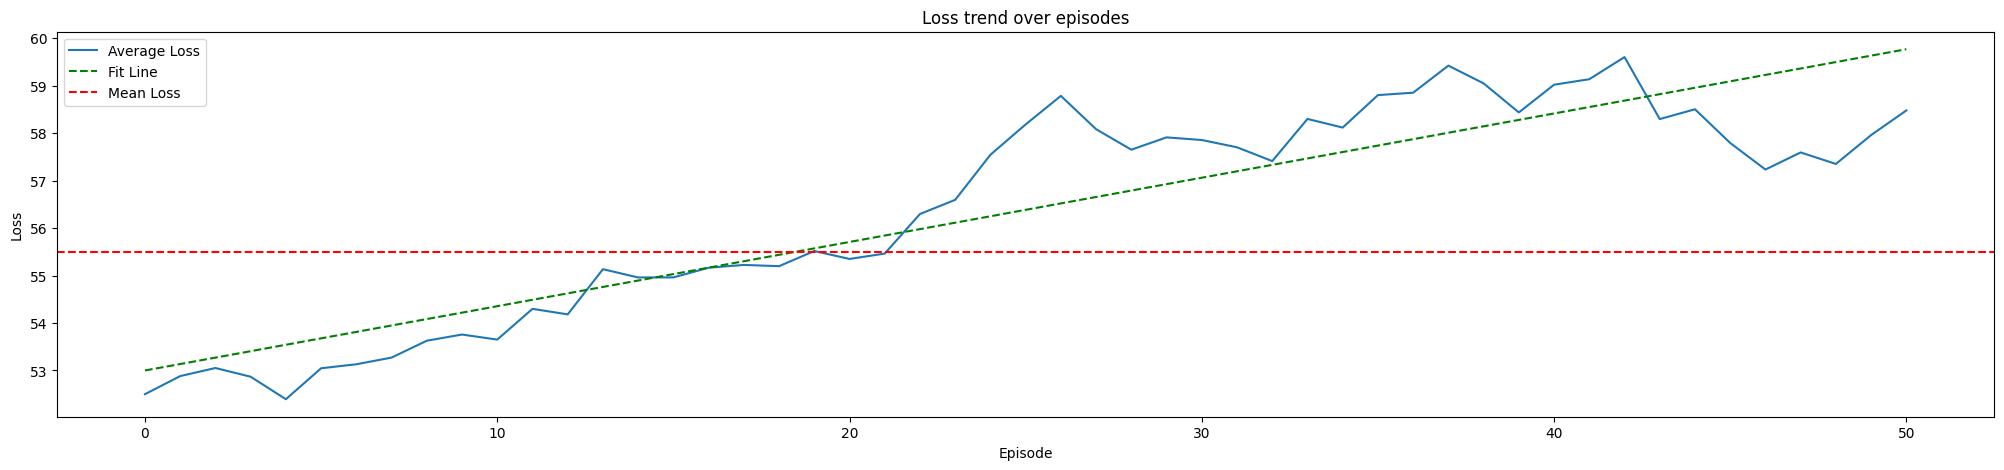

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltQ
from IPython.display import display, Image, Audio, clear_output
import ipywidgets as widgets

def music_feedback_interface(image_url, sound_source):
    like_button = widgets.Button(description='Like', button_style='success')
    dislike_button = widgets.Button(description='Dislike', button_style='danger')
    display(Image(url=image_url, format='png', width=300, height=300))
    display(widgets.HBox([like_button, dislike_button]))

    def on_button_click(b):
        like_button.close()
        dislike_button.close()

        feedback = 1 if b.description == 'Like' else 0
        clear_output()

    like_button.on_click(on_button_click)
    dislike_button.on_click(on_button_click)

    display(Audio(url=sound_source, autoplay=True))

class QLearningAgent:
    def __init__(self, num_actions, num_states, learning_rate=0.1, discount_factor=0.9, exploration_prob=0.1, last_state = "x"):
        self.num_actions = num_actions
        self.num_states = num_states
        self.q_table = np.zeros((num_states, num_actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.last_state = last_state
        self.states = {}
        self.losses = []

    def select_action(self, state):
        if np.random.rand() < self.exploration_prob:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_table[state, :])

    @staticmethod
    def load_data(file_path):
        return pd.read_csv(file_path)

    @staticmethod
    def preprocess_data(data):
        data = data.fillna(0)
        return data

    @staticmethod
    def state_representation(row):
        state_str = f"{row['GenreID']}_{row['ArtistID']}_{row['TrackID']}"
        hashed_state = hash(state_str) % 10000
        return hashed_state

    def simulate_recommendation_system(self, data, num_episodes=1000000):

        for episode in range(num_episodes):
            print("Episode number: " + str(episode))
            episode_loss = 0

            for _, row in data.iterrows():
                state = self.state_representation(row)
                self.states[state] = row
                action = self.select_action(state)
                reward = self.simulate_user_response(row)
                next_state = self.state_representation(row)
                loss = self.update_q_table(state, action, reward, next_state)
                episode_loss += loss

            self.losses.append(episode_loss)

        self.last_state = row

        window_size = 50
        avg_losses = np.convolve(self.losses, np.ones(window_size), 'valid') / window_size

        coeffs = np.polyfit(range(len(avg_losses)), avg_losses, 1)

        fit_line = coeffs[0] * np.array(range(len(avg_losses))) + coeffs[1]

        mean_loss = np.mean(self.losses)

        plt.figure(figsize=(25,5))
        plt.plot(avg_losses, label='Average Loss')
        plt.plot(fit_line, color='g', linestyle='--', label='Fit Line')
        plt.axhline(mean_loss, color='r', linestyle='--', label='Mean Loss')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.title('Loss trend over episodes')
        plt.legend()
        plt.show()


    def get_action(self):
        return self.last_state

    def recommend_music(self, data):
        state = self.state_representation(data.sample(n=1).iloc[0])
        action = np.argmax(self.q_table[state, :])
        recommended_data_row = data.iloc[action]

        return {
            'ImageLink': recommended_data_row['ImageLink'],
            'Preview': recommended_data_row['Preview'],
            'Title': recommended_data_row['Title'],
            'ArtistName': recommended_data_row['ArtistName'],
            'GenreID': recommended_data_row['GenreID'],
        }

    def simulate_user_response(self, row):
        return 1 if row['ArtistName'] == "Kanye West" else 0

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state, :])
        current_q = self.q_table[state, action]
        target_q = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        loss = (target_q - current_q)**2
        self.q_table[state, action] += self.learning_rate * (target_q - current_q)

        return loss

file_path = "/content/artists_output_with_top_tracks.csv"
music_data = QLearningAgent.load_data(file_path)
ql_agent = QLearningAgent(num_actions=2, num_states=10000)
ql_agent.simulate_recommendation_system(ql_agent.preprocess_data(music_data), num_episodes=100)

In [14]:
#print(ql_agent.states[np.argmax(ql_agent.q_table.T[0])])
image_url = ql_agent.states[np.argmax(ql_agent.q_table.T[0])]["ImageLink"]
sound_source = ql_agent.states[np.argmax(ql_agent.q_table.T[0])]["Preview"]
music_feedback_interface(image_url, sound_source)

In [ ]:
import matplotlib.pyplot as plt

window_size = 50
avg_losses = np.convolve(ql_agent.losses, np.ones(window_size), 'valid') / window_size
print(avg_losses)

coeffs = np.polyfit(range(len(avg_losses)), avg_losses, 1)

fit_line = coeffs[0] * np.array(range(len(avg_losses))) + coeffs[1]

mean_loss = np.mean(ql_agent.losses)

plt.figure(figsize=(25,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(fit_line, color='g', linestyle='--', label='Fit Line')
plt.axhline(mean_loss, color='r', linestyle='--', label='Mean Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss trend over episodes')
plt.legend()
plt.show()